In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from brian2 import *

In [2]:
facilitating = False
if facilitating:
    pars = {
        'tau_mem': 60,
        'R_in': 1000,
        'pre_rate': 70,
        'tau_inact': 1.5,
        'tau_rec': 130,
        'tau_facil': 530,
        'A_SE': 1540,
        'U_SE': 0.03
    }
else:
    pars = {
        'tau_mem': 40,
        'R_in': 100,
        'pre_rate': 20,
        'tau_inact': 3,
        'tau_rec': 800,
        'A_SE': 250,
        'U_SE': 0.6
    }


In [3]:
neuron_eqs =  """
tau_mem : second
I_syn : ampere
R_in : ohm
dV/dt = -V/tau_mem + (R_in*I_syn)/tau_mem : volt
"""
neuron = NeuronGroup(1, neuron_eqs, method='exact', name='neuron')
neuron.tau_mem = pars['tau_mem']*ms
neuron.R_in = pars['R_in']*Mohm

In [4]:
delay = 100*ms
n_spikes = 20
pre_firing_rate = pars['pre_rate']*Hz
pre_spike_times = delay + np.arange(n_spikes)/pre_firing_rate
indices = np.zeros(n_spikes)
stimulus = SpikeGeneratorGroup(1, indices, pre_spike_times, name='stimulus')

In [5]:
synapse_eqs = """
dx/dt =  z/tau_rec : 1 (clock-driven)    # fraction recovered
dy/dt = -y/tau_inact  : 1 (clock-driven) # fraction active
z = 1 - x - y : 1                        # fraction inactive
A_SE : ampere
U_SE : 1
tau_rec : second
tau_inact : second
I_syn_post = A_SE*y : ampere (summed)
"""

if facilitating:
    synapse_eqs = synapse_eqs + """
    du/dt = -u/tau_facil : 1 (clock-driven)
    tau_facil : second
    """
    synapse_actions = """
    u += U_SE*(1-u)
    y += u*x
    x -= u*x
    """
else:
    synapse_actions = """
    y += U_SE*x
    x -= U_SE*x
    """

synapse = Synapses(stimulus, neuron, model=synapse_eqs, on_pre=synapse_actions, method='exponential_euler')
synapse.connect(p=1)
synapse.x = 1
synapse.y = 0
synapse.tau_inact = pars['tau_inact']*ms
synapse.tau_rec = pars['tau_rec']*ms
if facilitating:
    synapse.tau_facil = pars['tau_facil']*ms
synapse.A_SE = pars['A_SE']*pA
synapse.U_SE = pars['U_SE']

In [6]:
neuron_mon = StateMonitor(neuron, ['V'], record=True)

In [7]:
tend = pre_spike_times[-1] + 5*pars['tau_mem']*ms
run(tend)
t = neuron_mon.t/ms
V = neuron_mon.V[0]/mV

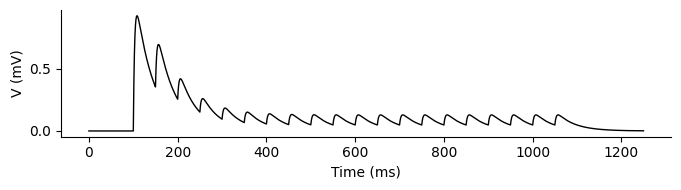

In [8]:
fig,ax = plt.subplots(1, 1, figsize=(7,2))
ax.plot(t, V, 'k', lw=1)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('V (mV)')
sns.despine()
fig.tight_layout()